# EOF Analysis

In [37]:
import numpy as np
import pandas as pd
from scipy import linalg
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Read SST data
f = 'data/era5_monthly_sst_5x5.nc'
da = xr.open_dataarray(f)

### Linear detrending

In [5]:
itime = xr.DataArray(np.arange(da.time.size), coords={'time': da.time})
poly_coef = da.reset_index('time', drop=True).polyfit(dim='time', deg=1)
trend = poly_coef.sel(degree=1) * itime + poly_coef.sel(degree=0)
da_detrend = da - trend['polyfit_coefficients']

### Anomaly

In [7]:
clm = da_detrend.groupby('time.month').mean()
anom = da_detrend.groupby('time.month') - clm
anom = anom.drop_vars('month')

### EOF

1. Weight the data by $ \sqrt{cos \phi} $

2. Reshape the data to (time, space)  
    2.1 Remove nans if necessary

3. SVD

4. Get PC and EOF

In [22]:
x = anom
nt, ny, nx = x.shape
print(f'{x.shape = :}')

# Weight the data with sqrt(cos(phi))
wgt = np.sqrt(np.cos(np.deg2rad(x.lat)))
x_wgt = x * wgt

# flatten to (time, space)
x_2d = x_wgt.data.reshape(x.shape[0], -1)
print(f'{x_2d.shape = :}')

# find grids containing nans
mask = np.any(np.isnan(x_2d), axis=0)
x_ma = x_2d[:, ~mask]
print(f'{mask.shape = :}')
print(f'{x_ma.shape = :}')

x.shape = (1008, 13, 72)
x_2d.shape = (1008, 936)
mask.shape = (936,)
x_ma.shape = (1008, 689)


In [96]:
# SVD
u, s, vh = linalg.svd(x_ma.T, full_matrices=False)
print(f'{u.shape = :}')
print(f'{s.shape = :}')
print(f'{vh.shape = :}')

u.shape = (689, 689)
s.shape = (689,)
vh.shape = (689, 1008)


check $E^T E = I$

In [103]:
ee = u @ u.T
print(np.allclose(ee, np.eye(ee.shape[0])))

True


In [97]:
# PC and PCA scores
pc = np.diag(s) @ vh
pca_score = s**2 / (s**2).sum()

# 1D space -> 2D lat, lon
n_mode = u.shape[1]
eof = np.empty((n_mode, ny*nx))
eof[:] = np.nan
eof[:, ~mask] = u.T
eof = eof.reshape(n_mode, ny, nx)
print(f'{pc.shape = :}')
print(f'{eof.shape = :}')

# Make xarray
eof_wgt = xr.DataArray(
    eof, 
    coords=[
        ('mode', np.arange(n_mode) + 1),
        ('lat', da.lat.data),
        ('lon', da.lon.data),
    ]
)
pc = xr.DataArray(
    pc, 
    coords=[
        ('mode', np.arange(n_mode) + 1),
        ('time', da.time.data),
    ]
)
pca_score = xr.DataArray(
    pca_score, coords=[('mode', np.arange(n_mode) + 1)],
)

# Reverse the weight
eof = eof_wgt / wgt

pc.shape = (689, 1008)
eof.shape = (689, 13, 72)


# Plot

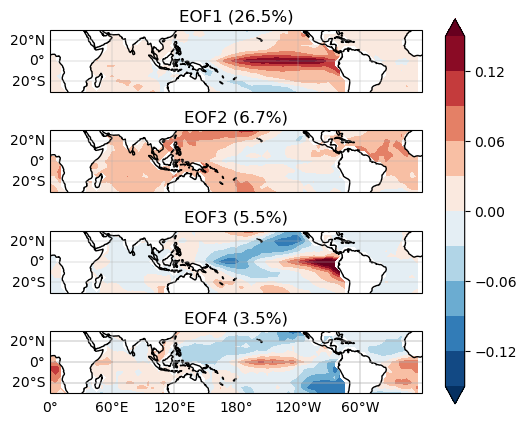

In [64]:
fig, axs = plt.subplots(
    ncols=1, nrows=4, # layout='constrained',
    figsize=(6, 5),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
)
for i, ax in enumerate(axs.flat):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left'], ylocs=[-20, 0, 20], lw=0.3)

    m = ax.contourf(
        eof.lon, eof.lat, eof.isel(mode=i),
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=np.linspace(-0.15, 0.15, 11), extend='both',
    )
    # plt.colorbar(m, ax=ax)
    ax.set_extent([0, 360, -30, 30], crs=ccrs.PlateCarree())

    ax.set(title=f'EOF{i+1} ({pca_score[i]*100:.1f}%)')
fig.colorbar(m, ax=axs)
axs[-1].gridlines(crs=ccrs.PlateCarree(), draw_labels=['bottom'], ylocs=[-20, 0, 20], lw=0.3)


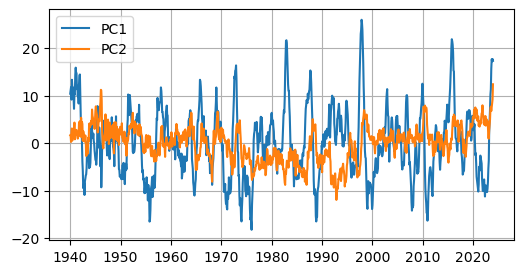

In [82]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pc.time, pc.sel(mode=1), label='PC1')
ax.plot(pc.time, pc.sel(mode=2), label='PC2')

ax.legend()
ax.grid()

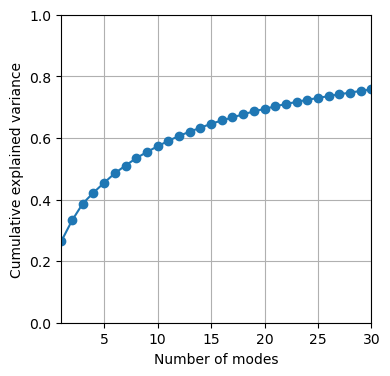

In [83]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(pca_score.mode, pca_score.cumsum(), marker='o')

ax.set(
    xlim=(1, 30), ylim=(0, 1),
    xlabel='Number of modes',
    ylabel='Cumulative explained variance'
)
ax.grid()

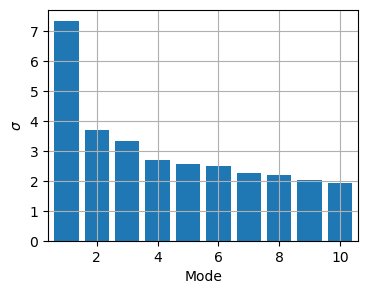

In [91]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(pc.mode, pc.std(dim='time'))
ax.set(
    xlim=(0.4, 10.6),
    xlabel='Mode',
    ylabel=r'$\sigma$',
)
ax.grid()